# Notebook to conduct Survival Analysis on telco Churn Dataset using Kaplan-Meier and Cox Proportional Hazards Models

The analysis is conducted using lifelines package. Some validation tools are taken from scikit-survival and sklearn.

In [135]:
!pip freeze | findstr "lifelines*"

lifelines==0.21.3


In [136]:
!pip freeze | findstr "scikit-survival*"

scikit-survival==0.8


In [137]:
import pandas as pd
import numpy as np

from collections import Counter 

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.plotting import plot_lifetimes
from lifelines.utils import concordance_index
from lifelines.statistics import proportional_hazard_test
from lifelines.utils import lowess

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import brier_score_loss

from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)


import pandas_profiling

%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [138]:
# data sourced from https://www.kaggle.com/blastchar/telco-customer-churn
# here, loading from a downloaded file
file_path = "C:\\Users\\elena\\Survival\\telco_customers.csv"
dftelco = pd.read_csv(file_path)

In [139]:
pandas_profiling.ProfileReport(dftelco) # 26% are churned, so majority is censored

Number of variables,21
Number of observations,7043
Total Missing (%),0.0%
Total size in memory,1.1 MiB
Average record size in memory,168.0 B
Numeric,2
Categorical,17
Boolean,1
Date,0
Text (Unique),1
Rejected,0


In [140]:
# pandas_profiling has a bug in sense that it modifies the global plt.style; reload matplotlib
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Populate Missing Total Charges with MonthlyCharges for Tenure=0 and Convert to Float

In [141]:
dftelco['TotalCharges'] = list(map(lambda x, y: y if x==' ' else float(x), 
                                  dftelco['TotalCharges'], dftelco['MonthlyCharges']))

## Split Data into Train and Test and Preserve Churn Dist in Both

If you stratify the train and test split, it is important to stratify on event-class and duration.

In [142]:
dftrain, dftest = train_test_split(dftelco, test_size=0.33, random_state=11, stratify=dftelco[['Churn', 'tenure']])

## One-Hot Encode Categorical and Encode Boolean-Like Features

In [143]:
bool_features = ['Dependents', 'PaperlessBilling', 'gender', 'PhoneService', 'Partner', 'Churn']
cat_features = list(set(dftrain.select_dtypes(exclude=["number","bool_"]).columns) - 
                    set(['customerID','TotalCharges','Churn']+bool_features))

In [144]:
oh_enc = OneHotEncoder(sparse=False)
oh_enc.fit(dftrain[cat_features])

# append field names to one-hot encoded field names
mod_cat_feature_names = oh_enc.get_feature_names(cat_features)

dftrain_trans = pd.DataFrame(data = oh_enc.transform(dftrain[cat_features]), 
                             columns = mod_cat_feature_names, 
                             index=dftrain.index)

dftrain_trans['customerID']= dftrain['customerID'].copy()
dftrain_trans['TotalCharges']=dftrain['TotalCharges'].copy()
dftrain_trans['MonthlyCharges']=dftrain['MonthlyCharges'].copy()
dftrain_trans['SeniorCitizen']=dftrain['SeniorCitizen'].copy()
dftrain_trans['tenure']=dftrain['tenure'].copy()

In [145]:
l_enc_list = []
for c in bool_features:
    l_enc = LabelEncoder()
    l_enc.fit(dftrain[c])
    l_enc_list.append(l_enc)
    dftrain_trans[c]=l_enc.transform(dftrain[c])

## Visualise Distibution of Churned Customers by Tenure

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FFA1863B38>,
      dtype=object)

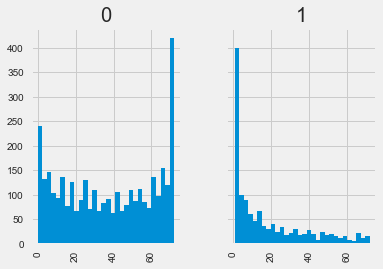

In [146]:
dftrain_trans.hist(column='tenure', by='Churn', sharex=True, sharey = True, bins=30, figsize=(6,4))

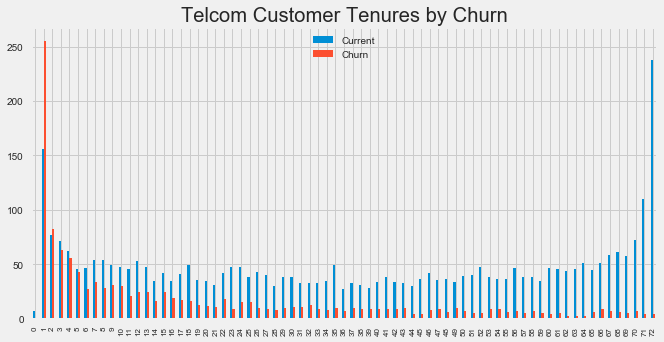

In [147]:
durationsubplot = pd.pivot_table(dftrain_trans[['tenure', 'Churn', 'customerID']], index=['tenure'], 
               columns=['Churn'], aggfunc='count').plot(kind='bar', use_index=False, 
                                                        xticks=None, yticks=None, figsize=(10,5))
durationsubplot.set_title('Telcom Customer Tenures by Churn')
durationsubplot.legend(['Current','Churn'])
durationsubplot.tick_params(axis='x', labelsize=8)

# Fit Kaplan-Meire Estimator

In [148]:
kmf = KaplanMeierFitter()

In [149]:
T = dftrain_trans['tenure']
E = dftrain_trans['Churn']

kmf.fit_right_censoring(durations=T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 4718 observations, 3469 censored>

In [150]:
kmf.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,7,0,7,4718,4718
1,411,255,156,0,4711
2,159,82,77,0,4300
3,134,63,71,0,4141
4,118,56,62,0,4007


In [151]:
kmf.event_table.tail()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
68,67,6,61,0,565
69,63,5,58,0,498
70,79,7,72,0,435
71,114,4,110,0,356
72,242,4,238,0,242


In [152]:
kmf.survival_function_at_times([0,1,2,3,4])

0    1.000000
1    0.945871
2    0.927834
3    0.913718
4    0.900948
Name: KM_estimate, dtype: float64

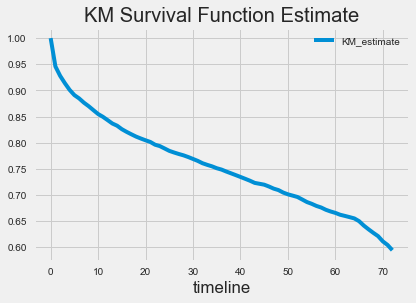

In [153]:
kmsubplot = kmf.survival_function_.plot()
kmsubplot = kmsubplot.set_title("KM Survival Function Estimate")  # Note the sharp decrease in the first two months!

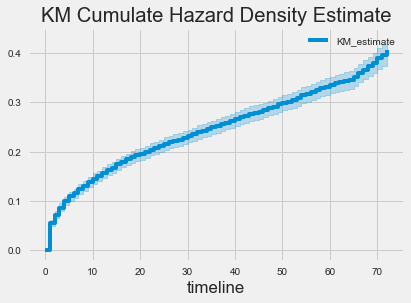

In [154]:
kmsubplot = kmf.plot_cumulative_density()
kmsubplot = kmsubplot.set_title("KM Cumulate Hazard Density Estimate")

In [155]:
# because we have right-censored data, predicted survival after the last observed tenure remains non-zero
kmf.predict([80,81,90])

80    0.594322
81    0.594322
90    0.594322
Name: KM_estimate, dtype: float64

# Fit Cox Proportional Hazards Regression

In [156]:
len(dftrain_trans.columns)

42

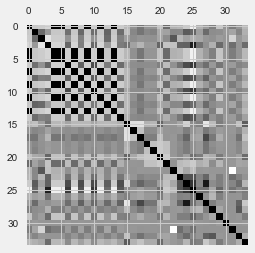

In [157]:
plt.matshow(dftrain_trans.loc[:, ~dftrain_trans.columns.isin(['customerID', 
                                                 'DeviceProtection_No',
                                                 'OnlineSecurity_No',
                                                  'OnlineBackup_No',
                                                  'StreamingTV_No',
                                                  'StreamingMovies_No',
                                                  'MultipleLines_No',
                                                  'TechSupport_No'])].corr())
plt.show()

### Remove Highly Correlated Column by Combining Them Into One
### Also Remove TotalCharges as It May Result in a Data Leak

In [158]:
dftrain_trans['NoInternet']=list(dftrain_trans['DeviceProtection_No internet service'])

cols_to_exclude =['customerID', 'DeviceProtection_No','OnlineSecurity_No','OnlineBackup_No',
                  'StreamingTV_No','StreamingMovies_No','MultipleLines_No','TechSupport_No',
                  'DeviceProtection_No internet service', 'OnlineSecurity_No internet service',
                  'OnlineBackup_No internet service', 'StreamingTV_No internet service',
                  'StreamingMovies_No internet service', 'MultipleLines_No phone service',
                  'TechSupport_No internet service', 'InternetService_No',
                   'TotalCharges']  #exclude total charges since it is highly correlated with duration

In [159]:
dftrain_use = dftrain_trans.loc[:, ~dftrain_trans.columns.isin(cols_to_exclude)].reset_index(drop=True).copy()

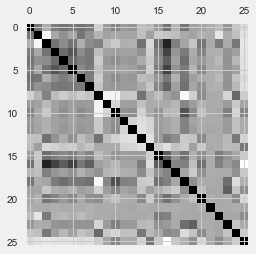

In [160]:
plt.matshow(dftrain_use.corr())
plt.show()

In [161]:
# initialise cph with a penalizer
cph = CoxPHFitter(penalizer=0.1)  # L2 penalizer
cph.fit(dftrain_use,
        duration_col='tenure', event_col='Churn',
        show_progress=True)

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -8774.22124, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 7 iterations.


<lifelines.CoxPHFitter: fitted with 4718 observations, 3469 censored>

In [162]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4718 observations, 3469 censored>
      duration col = 'tenure'
         event col = 'Churn'
         penalizer = 0.1
number of subjects = 4718
  number of events = 1249
partial log-likelihood = -8774.22
  time fit was run = 2019-07-11 19:59:41 UTC

---
                                         coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
TechSupport_Yes                         -0.39      0.67      0.16 -2.50   0.01      6.31       -0.70       -0.08
InternetService_DSL                      0.12      1.13      3.94  0.03   0.97      0.04       -7.60        7.85
InternetService_Fiber optic              0.57      1.76      3.98  0.14   0.89      0.17       -7.24        8.37
StreamingTV_Yes                         -0.03      0.97      0.28 -0.09   0.93      0.11       -0.58        0.53
DeviceProtection_Yes                    -0.38      0.68      0.15 -2.56   0.01      6.57       -0.68       -0.09
StreamingMovies_Yes             

<ul>
<li>Concordance is a measure of alignment between individual's estimated hazards and observed durations. The greater it is, the better is the model fit.</li>

<li>Log-likelihood ratio test a measure of improvement in accuracy by introducting the covariates over just using the baseline hazard. Again, the larger is the test score, the better.</li>

<li>Interperation of coefficients is as following: (exp{coef}-1)*100% = X% decrease/increase when 'yes' vs. when 'no'. For example, for 'OnlineSecurity_Yes' the impact on the hazard rate is (0.56-1)*100%=44% decrease in the hazard rate.</li>
</ul>
<b> Note: </b>Covariate signficance can be judged by the p-value.

### Re-fit CPH with a Smaller Set of Covariates

In [163]:
cph_reduced = CoxPHFitter(penalizer=0.1)
reduced_covariates_set = ['MultipleLines_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 
                          'Partner','TechSupport_Yes','Contract_Month-to-month', 'Contract_Two year',
                          'NoInternet', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)']
cph_reduced.fit(dftrain_use[reduced_covariates_set
                            +['tenure', 'Churn']],
        duration_col='tenure', event_col='Churn',
        show_progress=True)

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -8822.63465, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 7 iterations.


<lifelines.CoxPHFitter: fitted with 4718 observations, 3469 censored>

In [164]:
cph_reduced.print_summary()

<lifelines.CoxPHFitter: fitted with 4718 observations, 3469 censored>
      duration col = 'tenure'
         event col = 'Churn'
         penalizer = 0.1
number of subjects = 4718
  number of events = 1249
partial log-likelihood = -8822.63
  time fit was run = 2019-07-11 19:59:41 UTC

---
                                         coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
MultipleLines_Yes                       -0.35      0.71      0.06 -5.79 <0.005     27.04       -0.46       -0.23
OnlineSecurity_Yes                      -0.59      0.56      0.08 -7.53 <0.005     44.14       -0.74       -0.44
OnlineBackup_Yes                        -0.63      0.53      0.07 -9.47 <0.005     68.29       -0.76       -0.50
Partner                                 -0.54      0.58      0.06 -8.72 <0.005     58.36       -0.66       -0.42
TechSupport_Yes                         -0.49      0.61      0.08 -6.20 <0.005     30.72       -0.64       -0.33
Contract_Month-to-month         

<b>With only one third of the original features we achieve a very similar concordance and log-likelihood ratio test!</b>

Also, all of the covariates are not significant. Note that we now are using only binary covariates.

<b>Interpretation of the covariate coefficients:
No internet:
(exp{-1.20}-1)*100% = 70% decrease when 'yes'</b>

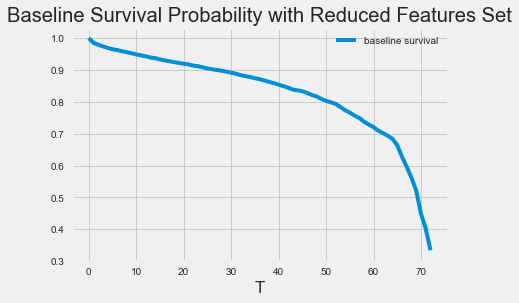

In [165]:
cph_reduced.baseline_survival_.plot(title="Baseline Survival Probability with Reduced Features Set")

# Estimate Fitted CPH on the Test Dataset

### Repeat Variable Transformation on the Test Dataset Using Trained Transformation Objects

In [166]:
dftest_trans = pd.DataFrame(data = oh_enc.transform(dftest[cat_features]), 
                             columns = mod_cat_feature_names, 
                             index=dftest.index)

dftest_trans['customerID']= dftest['customerID'].copy()
dftest_trans['TotalCharges']=dftest['TotalCharges'].copy()
dftest_trans['MonthlyCharges']=dftest['MonthlyCharges'].copy()
dftest_trans['SeniorCitizen']=dftest['SeniorCitizen'].copy()
dftest_trans['tenure']=dftest['tenure'].copy()

for i, c in enumerate(bool_features):
    dftest_trans[c]=l_enc_list[i].transform(dftest[c])
    
dftest_trans['NoInternet']=list(dftest_trans['DeviceProtection_No internet service'])
dftest_use = dftest_trans.loc[:, ~dftest_trans.columns.isin(cols_to_exclude)].reset_index(drop=True).copy()

In [167]:
cph_reduced.predict_survival_function(dftest_use).head()

,0,1,2,3,4,5,6,7,8,9,...,2315,2316,2317,2318,2319,2320,2321,2322,2323,2324
T,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.997669,0.808530,0.956498,0.974379,0.808530,0.930347,0.998707,0.883129,0.808530,0.936071,...,0.999740,0.992870,0.998505,0.808530,0.955039,0.808530,0.996392,0.915794,0.888718,0.892964
2.0,0.996715,0.741073,0.939219,0.964068,0.741073,0.903218,0.998178,0.839266,0.741073,0.911063,...,0.999634,0.989962,0.997893,0.741073,0.937199,0.741073,0.994917,0.883362,0.846764,0.852473
3.0,0.995905,0.688144,0.924767,0.955384,0.688144,0.880766,0.997728,0.803676,0.688144,0.890318,...,0.999544,0.987495,0.997373,0.688144,0.922287,0.688144,0.993664,0.856682,0.812641,0.819481
4.0,0.995121,0.640522,0.910992,0.947053,0.640522,0.859568,0.997292,0.770669,0.640522,0.870691,...,0.999456,0.985114,0.996869,0.640522,0.908081,0.640522,0.992452,0.831628,0.780927,0.788768


## Calculate Concordance Indices on the Test Dataset

lifelines and scikit-survival packages allow for calculation of concordance index on the test dataset using partial hazard estimates from the model fitted on the train dataset.

Note that we need to negate the predicted partial hazards.

In [168]:
concordance_index(dftest_trans['tenure'], -cph_reduced.predict_partial_hazard(dftest_use), dftest_trans['Churn'])

0.8650917222543525

#### scikit-survival requires some data transformation

In [169]:
dftrain_use['churn_boolean'] = list(map(bool, dftrain_use['Churn']))
dftrain_use['tenure_float'] = list(map(float, dftrain_use['tenure']))

dftest_use['churn_boolean'] = list(map(bool, dftest_use['Churn']))
dftest_use['tenure_float'] = list(map(float, dftest_use['tenure']))

In [170]:
y_train = dftrain_use[['churn_boolean', 'tenure_float']].to_records(index=False)
y_test = dftest_use[['churn_boolean', 'tenure_float']].to_records(index=False)

x_test = cph_reduced.predict_partial_hazard(dftest_use).get_values().ravel()

print(concordance_index_censored(y_test['churn_boolean'], y_test['tenure_float'], x_test))

(0.8650917222543525, 830697, 121150, 19891, 21704)


# Calculate Uno's IPCW Concordance with scikit-survival

In [171]:
y_train = dftrain_use[['churn_boolean', 'tenure_float']].to_records(index=False)
y_test = dftest_use[['churn_boolean', 'tenure_float']].to_records(index=False)

x_test = cph_reduced.predict_partial_hazard(dftest_use).get_values().ravel()

concordance_index_ipcw(y_train, y_test, x_test)

(0.8871992929315377, 830697, 121150, 19891, 21704)

# Calculate Time-Dependent AUC on Test Data

Text(0.5,1,'Time-dependent AUC for telco data')

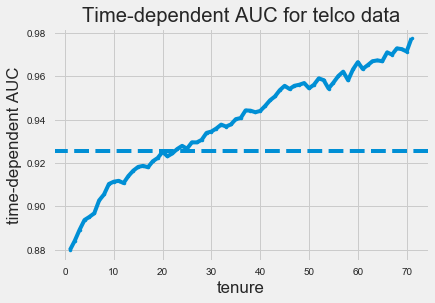

In [172]:
times = range(1,max(dftest_use['tenure']))
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, x_test, times)

plt.plot(times, auc, marker=".")
plt.axhline(mean_auc, linestyle="--")
plt.xlabel("tenure")
plt.ylabel("time-dependent AUC")
plt.grid(True)
plt.title("Time-dependent AUC for telco data")

In [173]:
mean_auc

0.9256392841075697

# Visualise Brier Score Losses

<b>Brier Score Loss is the squared difference between event and its predicted probability at each tenure.

It should be compared with the null-model's score.

For a single point 'reference' a Brier score of 0.25 - is the 'fence-sitter', forecasting churn as 50-50 (see https://www.stata.com/manuals13/rbrier.pdf).</b>

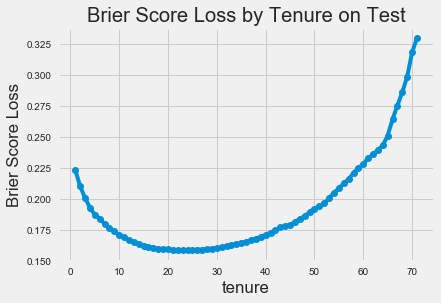

In [174]:
bscores = {}
pred_survivals = np.array(cph_reduced.predict_survival_function(dftest_trans))
for i in times:
    bscore = brier_score_loss(dftest_trans['Churn'], 1 - pred_survivals[i],
                             pos_label=1.0)
    bscores[i] = [bscore]

plt.plot(bscores.keys(), bscores.values(), marker="o")
plt.xlabel('tenure')
plt.ylabel('Brier Score Loss')
plt.title('Brier Score Loss by Tenure on Test')
plt.grid(True)
plt.show()

Between 10 and 45 month durations we are one average predicting a survival probability of 60% while it is 1.
Or, equaly saying that someone will churn with probality of 40% and then do not churn.

Most observations past 60 months duration are censored, where Brier score may not be a valid estimator.
Brier score can broken down into calibration, resolution and uncertainty.

## Calculate Martingale Residuals

In [175]:
rmart = cph_reduced.compute_residuals(dftrain_use, 'martingale')

In [176]:
#calculate mean martingale residual by tenure
mean_rmart = rmart.groupby(by=['tenure'])['martingale'].mean().reset_index()

In [177]:
# calculate lowess lines
lw = lowess.lowess(mean_rmart['tenure'], mean_rmart['martingale'])

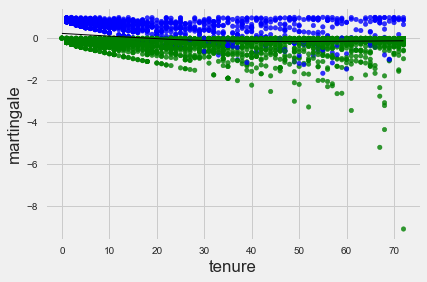

In [178]:
plt_rmart = rmart.plot.scatter(
    x='tenure', y='martingale', c=np.where(rmart['Churn'], 'blue', 'green'), alpha=0.80) # green is current, blue is churned
plt_rmart.plot(mean_rmart['tenure'].values, lw, color='k', alpha=1.0, linewidth=1)

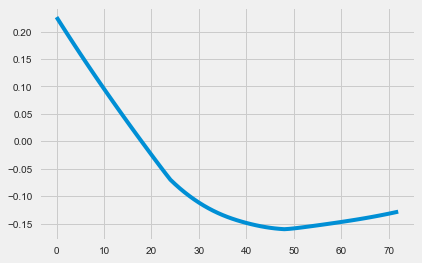

In [179]:
plt.plot(mean_rmart['tenure'].values, lw)

### Add Covariates to the Martingale Residual Dataframe for Visualisation

In [180]:
for c in reduced_covariates_set:
    rmart[c] = dftrain_use[c].copy()

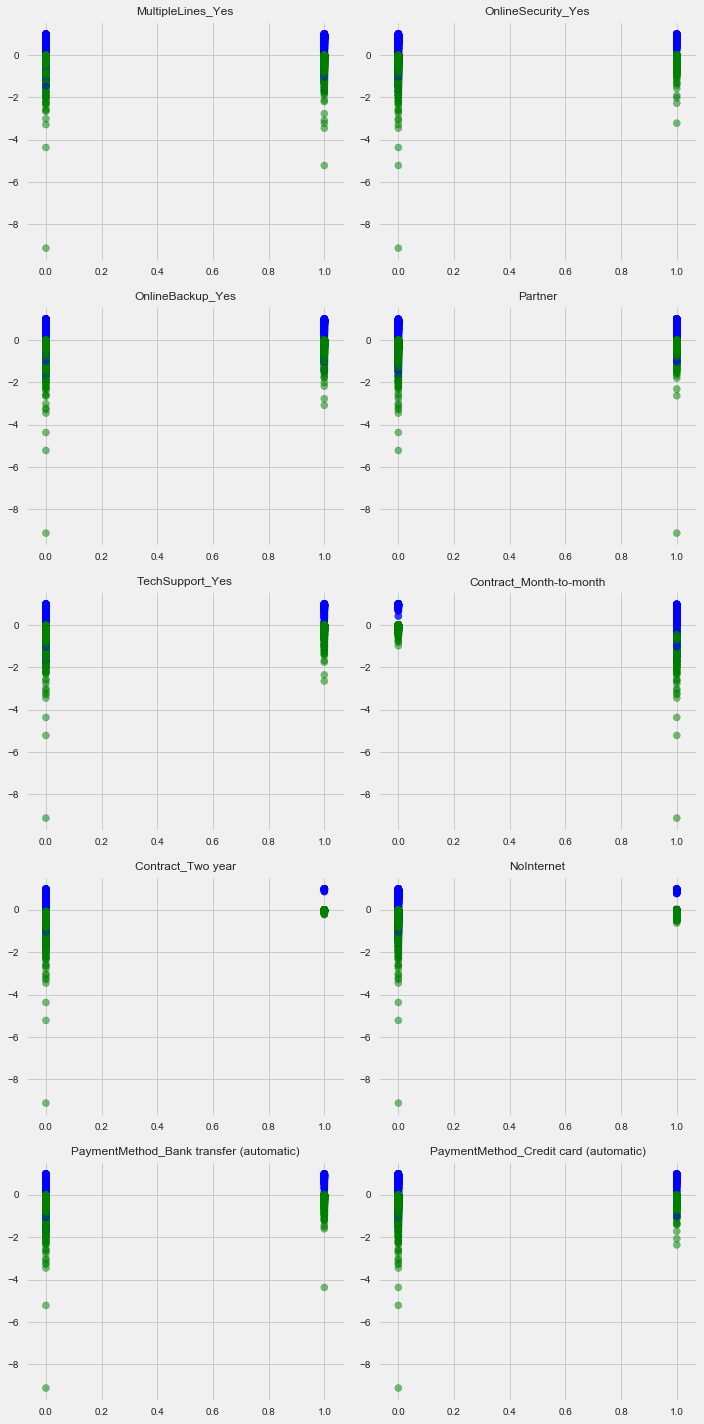

In [181]:
f, axarr = plt.subplots(5,2)
coord = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]
for i,c in enumerate(reduced_covariates_set):
    axarr[coord[i][0],coord[i][1]].scatter(x=rmart[c], y=rmart['martingale'], c=np.where(rmart['Churn'], 'blue', 'green'), alpha=0.5)
    axarr[coord[i][0],coord[i][1]].set_title(c,{'fontsize':12})

f.subplots_adjust(hspace=0.2,wspace=0.2)
f.set_size_inches(w=10,h=20)
f.tight_layout()
plt.show()

Binary features are not going to show non-linearity in residuals. However, it is good to inspect the distribution and the magnitude by the covariate value.

### Deviance Residuals

In [182]:
rdev = cph_reduced.compute_residuals(dftrain_use, 'deviance')

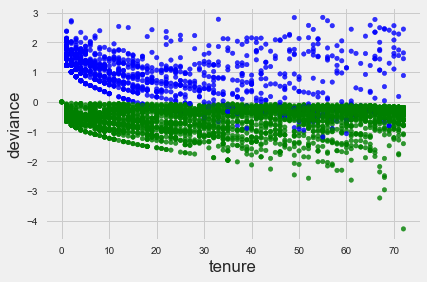

In [183]:
rdev.plot.scatter(
    x='tenure', y='deviance', c=np.where(rmart['Churn'], 'blue', 'green'), alpha=0.80) # green is current, blue is churned

Deviance residuals have the same meaning for the sing as the martingale residuals:
 - positive means 'died' sooner than expected
 - negative means 'lived' longer than expected or censored

### Score Residuals - Spotting Influencial Data Points

In [184]:
rscore = cph_reduced.compute_residuals(dftrain_use[reduced_covariates_set+['tenure','Churn']], 'score')

In [185]:
rscore.columns

Index(['MultipleLines_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'Partner', 'TechSupport_Yes', 'Contract_Month-to-month',
       'Contract_Two year', 'NoInternet',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)'],
      dtype='object')

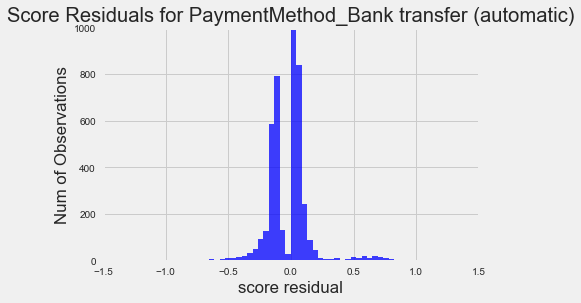

In [186]:
n, bins, patches = plt.hist(rscore['PaymentMethod_Bank transfer (automatic)'], 50, facecolor='blue', alpha=0.75)

plt.xlabel('score residual')
plt.ylabel('Num of Observations')
plt.title('Score Residuals for PaymentMethod_Bank transfer (automatic)')
plt.axis([-1.5, 1.5, 0, 1000])
plt.grid(True)

plt.show()

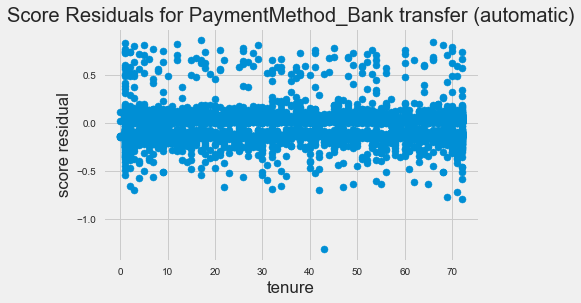

In [187]:
plt.scatter(dftrain_trans['tenure'], rscore['PaymentMethod_Bank transfer (automatic)'])
plt.xlabel('tenure')
plt.ylabel('score residual')
plt.title('Score Residuals for PaymentMethod_Bank transfer (automatic)')
plt.grid(True)

plt.show()

### Schoenfeld Residuals - Stratified Model

In [188]:
rsch = cph_reduced.compute_residuals(dftrain_use[reduced_covariates_set+['tenure','Churn']], 'scaled_schoenfeld')

### Proportional Hazard Test Using lifelines

In [189]:
res = proportional_hazard_test(cph_reduced, dftrain_use[reduced_covariates_set
                            +['tenure', 'Churn']])

In [190]:
res.print_summary()

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1

---
                                         test_statistic      p  -log2(p)
Contract_Month-to-month                           27.63 <0.005     22.70
Contract_Two year                                  0.03   0.85      0.23
MultipleLines_Yes                                 35.57 <0.005     28.60
NoInternet                                         7.52   0.01      7.36
OnlineBackup_Yes                                   4.45   0.03      4.84
OnlineSecurity_Yes                                 4.38   0.04      4.78
Partner                                            6.31   0.01      6.38
PaymentMethod_Bank transfer (automatic)            4.53   0.03      4.91
PaymentMethod_Credit card (automatic)             10.47 <0.005      9.69
TechSupport_Yes                                   13.91 <0.005     12.35


The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                                              test_statistic      p  -log2(p)
Contract_Month-to-month                 km             37.39 <0.005     29.95
                                        rank           27.63 <0.005     22.70
Contract_Two year           

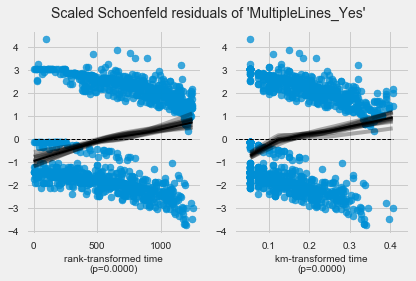

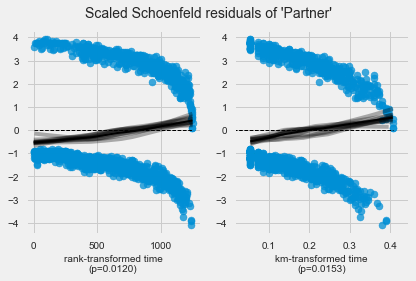

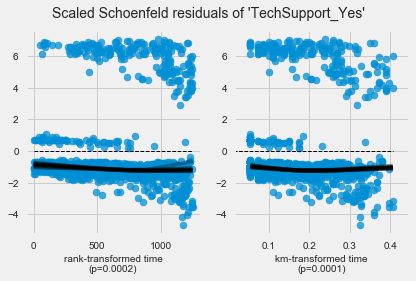

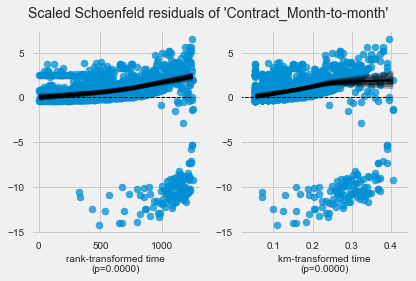

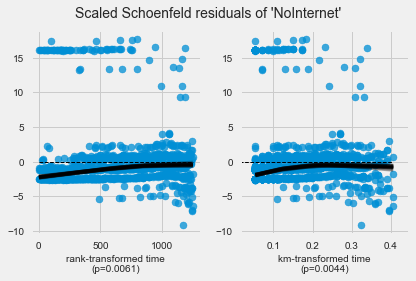

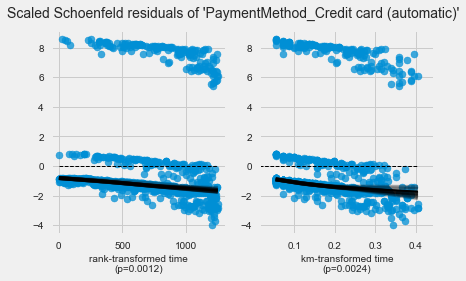

In [191]:
cph_reduced.check_assumptions(dftrain_use[reduced_covariates_set+['tenure','Churn']], show_plots=True)

## Refit- CPH with Stratified Covariates

In [192]:
cph_reduced.fit(dftrain_use[reduced_covariates_set+['tenure', 'Churn']],
        duration_col='tenure', event_col='Churn',
        show_progress=True, strata=['MultipleLines_Yes','OnlineBackup_Yes',
                                    'Contract_Month-to-month',
                                    'TechSupport_Yes', 'Partner', 'PaymentMethod_Credit card (automatic)'])

Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -5396.93970, newton_decrement = 0.00000, seconds_since_start = 3.6Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 4718 observations, 3469 censored>

In [193]:
cph_reduced.print_summary()

<lifelines.CoxPHFitter: fitted with 4718 observations, 3469 censored>
      duration col = 'tenure'
         event col = 'Churn'
            strata = ['MultipleLines_Yes', 'OnlineBackup_Yes', 'Contract_Month-to-month', 'TechSupport_Yes', 'Partner', 'PaymentMethod_Credit card (automatic)']
         penalizer = 0.1
number of subjects = 4718
  number of events = 1249
partial log-likelihood = -5396.94
  time fit was run = 2019-07-11 20:00:53 UTC

---
                                         coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
OnlineSecurity_Yes                      -0.60      0.55      0.08 -7.44 <0.005     43.15       -0.76       -0.44
Contract_Two year                       -2.08      0.12      0.23 -8.94 <0.005     61.13       -2.54       -1.63
NoInternet                              -1.02      0.36      0.12 -8.31 <0.005     53.17       -1.27       -0.78
PaymentMethod_Bank transfer (automatic) -0.59      0.55      0.09 -6.62 <0.005     34.69       -0

In [194]:
cph_reduced.check_assumptions(dftrain_use[reduced_covariates_set+
                                          ['tenure', 'Churn']], show_plots=True)

Proportional hazard assumption looks okay.


Apart from stratification, non-proportionality can be dealt with by using time-varying CPH or a non-CPH model.